In [2]:
!pip install nilearn

# **PLS based SC and FC**

## **Partial Least Square Analysis to study Structure-Function Relationship**

**Reference:**
1. Mišić, Bratislav, et al. "Network-level structure-function relationships in human neocortex." Cerebral Cortex 26.7 (2016): 3285-3296.


**Descriptions:**
1. PLS is a multivariate statistical technique used to relate two sets of variables to each other. 
2. The goal of the analysis is to simultaneously find linear combinations of variables in each block that maximally covary with each other. 
3. In the present analysis, this corresponds to a weighted combination of structural connections (interpreted as a structural network) and a weighted combination of functional connections (interpreted as a functional network).

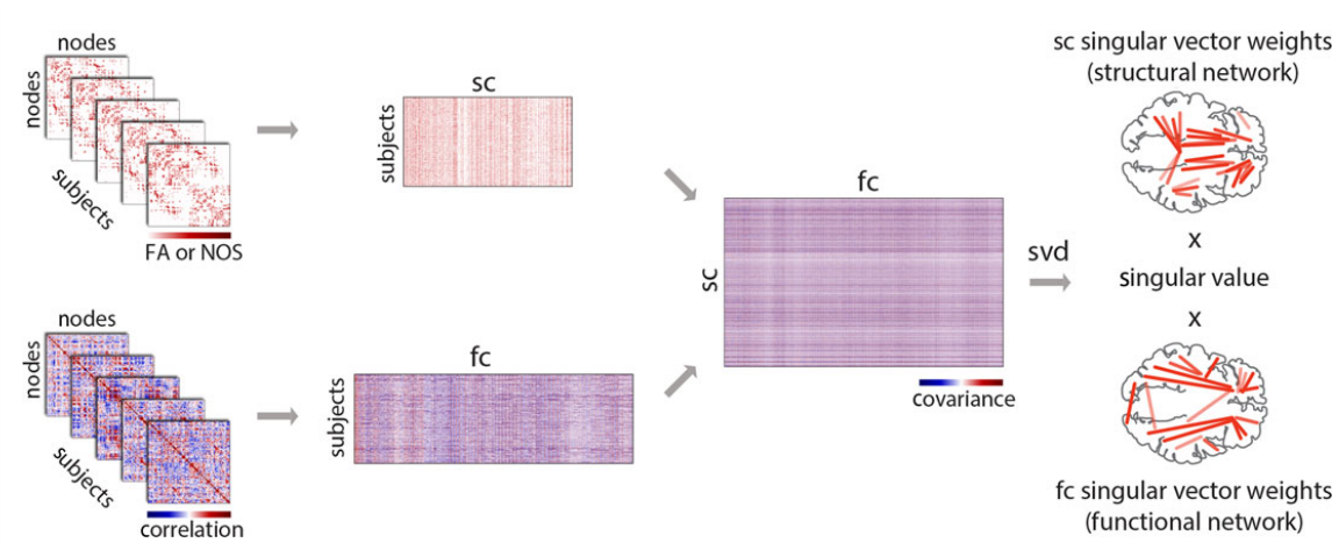

### **Load Data**

In [3]:
import os
import pandas as pd
import scipy.io as scio
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class SC_FT_dataset(Dataset):
  def __init__(self):
    super().__init__()
    data=scio.loadmat('./data/aal_data.mat')  
    self.train_sc=torch.from_numpy(data['SC'])
    self.train_ft1=torch.from_numpy(data['FT1'])
    self.train_ft2=torch.from_numpy(data['FT2'])

  def __len__(self):
    return self.train_sc.shape[0]

  def __getitem__(self, index):
    sc=self.train_sc[index]
    ft1=self.train_ft1[index]
    ft2=self.train_ft2[index]
    return sc, ft1, ft2

sc_ft_data_train=SC_FT_dataset()

### **Generating FC**

To ensure that the differences in structural and functional connection magnitudes do not dominate the statistical model, 
the structural and functional data matrices were z-scored columnwise, by subtracting the mean from each column and dividing by the standard deviation of that column. 

Thus, in the present analyses the covariance matrix was effectively converted to a correlation matrix prior to decomposition.

In [4]:
from nilearn.connectome import ConnectivityMeasure

ft = sc_ft_data_train.train_ft1.numpy()
fc = np.zeros((ft.shape[0],ft.shape[1],ft.shape[1]))

for i in range(ft.shape[0]):
  correlation_measure = ConnectivityMeasure(kind='correlation')
  fc[i,:] = correlation_measure.fit_transform([ft[i,:,400:600].T])[0]

sub_fc = np.zeros((fc.shape[0],int(fc.shape[1]*(fc.shape[1]-1)/2)))

index=0
for m in range(90-1):
  for n in range(m+1,90):
    sub_fc[:,index]=fc[:,m,n]
    index+=1
sub_fc.shape

from scipy.stats import zscore
z_sub_fc=zscore(sub_fc,1)

### **Obtain SC**

In [5]:
sc = sc_ft_data_train.train_sc.numpy()

sub_sc = np.zeros((sc.shape[0],int(sc.shape[1]*(sc.shape[1]-1)/2)))

# for i in range(sc.shape[0]):
  # sc_[i,:] = np.reshape(sc[i,:,:],(sc.shape[1]*sc.shape[1],))
index=0
for m in range(90-1):
  for n in range(m+1,90):
    #print(n)
    sub_sc[:,index]=sc[:,m,n]
    index+=1
sub_sc.shape

z_sub_sc=zscore(sub_sc,1)

### **Obtain SC & FC covariance matrix**

The covariance between structural and functional connections was computed across participants, resulting in a rectangular SC–FC covariance matrix. 

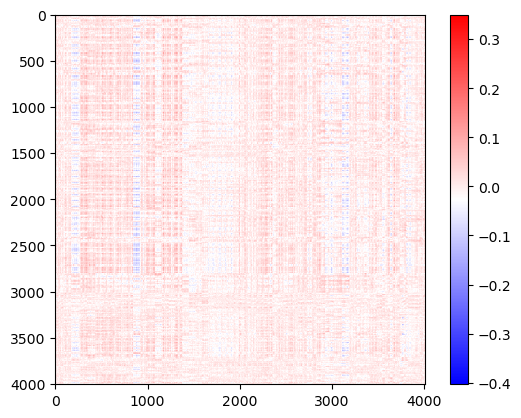

In [6]:
import numpy as np

sc_fc_cov=np.corrcoef(z_sub_sc.T,z_sub_fc.T,rowvar=True)[:z_sub_sc.shape[1],z_sub_sc.shape[1]:]

import matplotlib.pyplot as plt
plt.imshow(sc_fc_cov,cmap='bwr')
plt.colorbar()

### **SVD for SC & FC correlation matrix**

In [7]:
u, s, v = np.linalg.svd(sc_fc_cov)

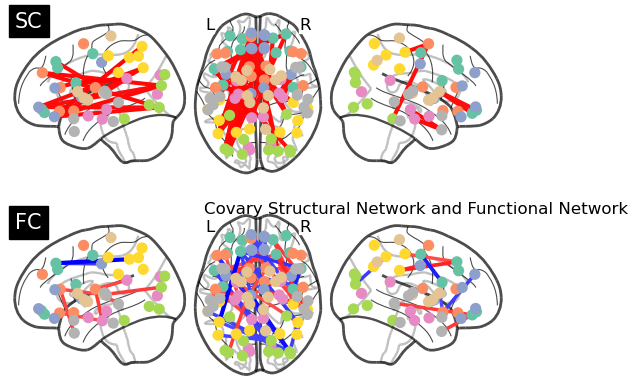

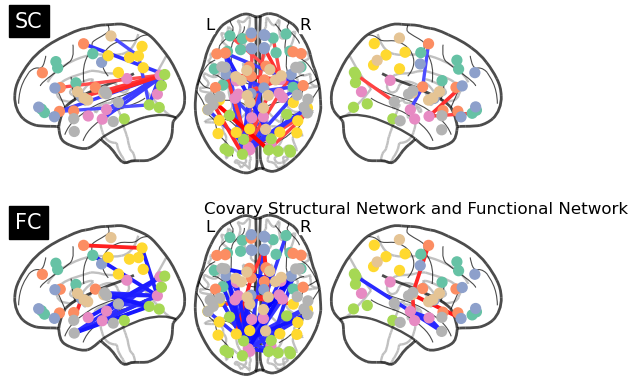

In [9]:
from nilearn import plotting
from nilearn import datasets
aal_atlas = datasets.fetch_atlas_aal().maps

atlas_region_coords = plotting.find_parcellation_cut_coords(aal_atlas)

for i in range(2):
    sc_i=np.zeros((90,90))
    index=0
    for m in range(90-1):
        for n in range(m+1,90):
            sc_i[m,n]=u[index,i]
            index+=1
    sc_i+=sc_i.T

    fc_i=np.zeros((90,90))
    index=0
    for m in range(90-1):
        for n in range(m+1,90):
            fc_i[m,n]=v[i,index]
            index+=1
    fc_i+=fc_i.T

    # plt.figure(figsize=(20,5))
    fig,ax=plt.subplots(2,1)
    plotting.plot_connectome(sc_i,
                atlas_region_coords[:90,:], edge_threshold='99%',
                title="SC",
                display_mode="lzr",
                axes=ax[0])
    
    plotting.plot_connectome(fc_i,
                atlas_region_coords[:90,:], edge_threshold='99%',
                title="FC",
                display_mode="lzr",
                axes=ax[1])
    plt.title('Covary Structural Network and Functional Network')